In [287]:
# Stock Price Predictiong Using Python & Machine Learning with LSTM model (Long Short Term Memory)

In [288]:
# import libraries
import math                                    # mathematical functions        https://docs.python.org/3/library/math.html
import pandas_datareader as web                # data reader for panda         https://pandas-datareader.readthedocs.io/en/latest/
import numpy as np                             # numerical data in python      https://numpy.org/doc/stable/user/absolute_beginners.html
import pandas as pd                            # data analysis toolkit         https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt                # plotting data in figures      https://matplotlib.org/2.0.2/users/pyplot_tutorial.html
from sklearn.preprocessing import MinMaxScaler # raw data utility functions    https://scikit-learn.org/stable/modules/preprocessing.html
from keras import metrics as metrics
import tensorflow as tf
from keras.models import Sequential            # input output sequence of data https://www.tensorflow.org/guide/keras/sequential_model
from datetime import datetime, timedelta       # for manipulating dates        https://docs.python.org/3/library/datetime.html
from keras.layers import Dense, LSTM, Dropout  # layers for neural network     https://keras.io/api/layers/
plt.style.use('fivethirtyeight')               # plot style                    https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

ModuleNotFoundError: No module named 'keras'

In [289]:
# Stock attributes
stock = 'GOOGL'
source = 'yahoo'
today = datetime.now() # todays date (YYYY-MM-DD HH:MM:SS)
years = 20            # years back to start from when grabbing stocks, i.e 10 years = 2020-10 = 2010
startYear = today-timedelta(days=365*years)

# Get stock data using pandas data reader
df = web.DataReader(stock, data_source=source, start=startYear, end=today)

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,52.082081,48.028027,50.050049,50.220219,44659096.0,50.220219
2004-08-20,54.594597,50.300301,50.555557,54.209209,22834343.0,54.209209
2004-08-23,56.796799,54.579578,55.430431,54.754753,18256126.0,54.754753
2004-08-24,55.855858,51.836838,55.675674,52.487488,15247337.0,52.487488
2004-08-25,54.054054,51.991993,52.532532,53.053055,9188602.0,53.053055
...,...,...,...,...,...,...
2021-11-17,2971.189941,2944.800049,2960.550049,2960.939941,979700.0,2960.939941
2021-11-18,3011.610107,2957.689941,2964.830078,2996.770020,1780400.0,2996.770020
2021-11-19,3019.330078,2977.979980,2999.510010,2978.530029,1684100.0,2978.530029


In [290]:
# Get rows and columns from the dataframe
df.shape

(4348, 6)

Text(0, 0.5, 'Close Price USD ($)')

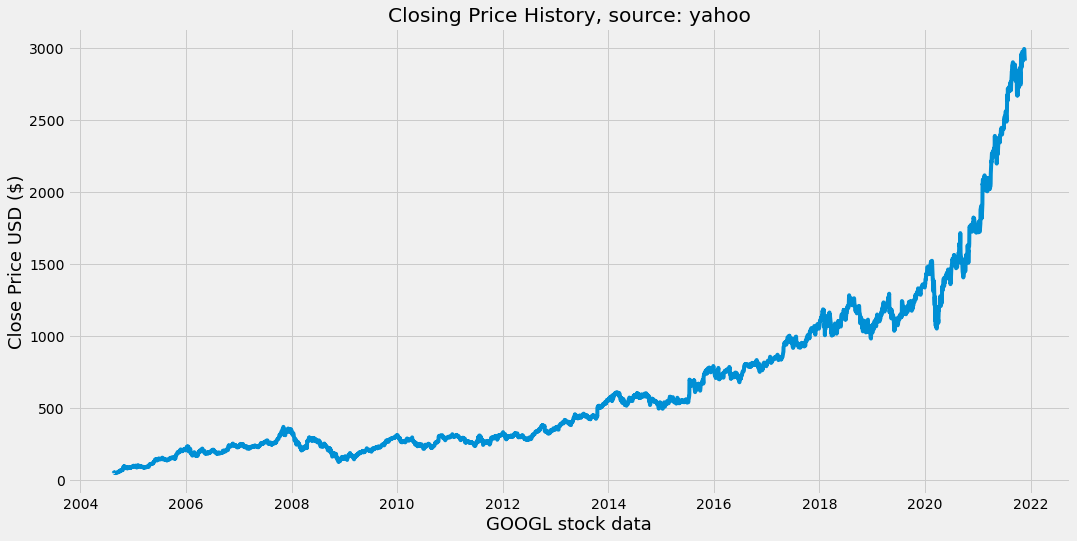

In [291]:
# Show closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History, source: ' + source)
plt.plot(df['Close'])
plt.xlabel(stock + ' stock data', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

In [292]:
# Create new dataframe with 'Close' column
data_target = df.filter(['Close'])

# Covert dataframe into a numpy array with a 1 day delay
dataset = data_target.shift(-1, fill_value=0).values

# Get the number of rows to train the model on, using 80% of the data
training_data_len = math.ceil(len(dataset) * .8)

# Scale data between 0 and 1 to avoid the bias using normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01808921],
       [0.01827126],
       [0.01751469],
       ...,
       [0.97639793],
       [0.97292748],
       [0.        ]])

In [293]:
# Create training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]

# Split data into x_train and y_train datasets
time_interval = int(len(dataset)*0.05) # amount of steps to train on, I.E the amount of data the LSTM uses per "step" ex: [0,1,2....60] if time_interval = 10 first LSTM step will be 0-9 and predict 10, second step woule be 1-10 and predict 11. =
x_train = []   # past x days, using previous example this would be 0-9
y_train = []   # predicted target value.              this would be predicted value for 10

# loop for the last x days
for i in range(time_interval, len(train_data)):
    x_train.append(train_data[i-time_interval:i, 0]) # append closingprice for i day
    y_train.append(train_data[i, 0])             # append predicted value
    
# Convert x_train and y_train to numpy arrays to use in LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data from 2D to 3D
# LSTM network needs 3D input (number of samples, timesteps and features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3262, 217, 1)

In [294]:
# Build LSTM model
model = Sequential()

# # Run first layer with train data as input, 250 nodes, drop 20% when done, only return last output
# model.add(LSTM(250, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))

# # Run a second layer with 250 nodes, drop 10% 
# model.add(LSTM(250, return_sequences=True))
# model.add(Dropout(0.1))

# Run a third layer with 50 nodes, drop 10% when done return whole output
model.add(LSTM(500, return_sequences=False))
model.add(Dropout(0.1))

# Run a fourth layer with 25 nodes and 10% dropout
model.add(Dense(25))
model.add(Dropout(0.1))

model.add(Dense(units = 1))


In [295]:
# Method for calculating RMSE used for loss in model.compile
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [296]:
# Compile model
# Optimizer is to improve upon the loss function https://keras.io/api/optimizers/adam/
# loss function is used to measure how good the model did on training in terms of RMSE
# Metrics is used to evaluate the accuracy of predicitons (currently does not work)
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=[
        metrics.MeanSquaredError(name="MSE"),
        metrics.MeanAbsoluteError(name="MAE"),
        metrics.MeanSquaredLogarithmicError(name="MSLE")
    ]
)

In [297]:
# Train model
# Batch size is the total number of training examples present in a single batch.
# Epoch is the number of iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=48, epochs=10)

Epoch 1/10
68/68 [==============================] - 104s 1s/step - loss: 0.0277 - MSE: 0.0016 - MAE: 0.0215 - MSLE: 0.0011
Epoch 2/10
68/68 [==============================] - 100s 1s/step - loss: 0.0149 - MSE: 2.3265e-04 - MAE: 0.0103 - MSLE: 1.5309e-04
Epoch 3/10
68/68 [==============================] - 101s 1s/step - loss: 0.0134 - MSE: 1.8725e-04 - MAE: 0.0097 - MSLE: 1.2525e-04
Epoch 4/10
68/68 [==============================] - 96s 1s/step - loss: 0.0126 - MSE: 1.7004e-04 - MAE: 0.0089 - MSLE: 1.1157e-04
Epoch 5/10
68/68 [==============================] - 96s 1s/step - loss: 0.0119 - MSE: 1.4705e-04 - MAE: 0.0081 - MSLE: 9.5755e-05
Epoch 6/10
68/68 [==============================] - 100s 1s/step - loss: 0.0112 - MSE: 1.3077e-04 - MAE: 0.0076 - MSLE: 8.4858e-05
Epoch 7/10
68/68 [==============================] - 100s 1s/step - loss: 0.0111 - MSE: 1.2948e-04 - MAE: 0.0077 - MSLE: 8.3863e-05
Epoch 8/10
68/68 [==============================] - 99s 1s/step - loss: 0.0104 - MSE: 1.1351e

In [298]:
# Create testing dataset
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - time_interval: :]

# Create the data sets x_test and y_test
x_test = [] # past x days
y_test = dataset[training_data_len:, :] # predicted value

# loop for the last x days
for i in range(time_interval, len(test_data)):
    x_test.append(test_data[i-time_interval:i, 0]) # append closing price for i day
    
# Convert data into a numpy array to use in LSTM model
x_test = np.array(x_test)

# Reshape data from 2D to 3D
# LSTM network needs 3D input (number of samples, timesteps and features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(869, 217, 1)

In [299]:
# Get model predicted unscaled closingprice value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [300]:
# calculates the accuracy of our predictions against the actual values within a given percentile
def accuracy_calc(percentage):
    actual = y_test
    ok_accuracy = 0
    total = actual.size
    threshold = (100 - percentage) / 100
    lower = 1-threshold
    upper = 1+threshold

    for i in range(total):
        cur_act = actual[i]
        cur_pred = predictions[i]
        if cur_act >= cur_pred*lower and cur_act <= cur_pred*upper:
            ok_accuracy +=1
    acc = ok_accuracy/total
    print(f"Percentage of predicted values within {percentage}% margin of actual: {acc}")

In [301]:
print("RMSE: ", root_mean_squared_error(y_test, predictions))
accuracy_calc(50)
accuracy_calc(60)
accuracy_calc(70)
accuracy_calc(80)
accuracy_calc(90)
accuracy_calc(95)
accuracy_calc(99)

# Evaluate model 
model.evaluate(x_test, y_test, batch_size=8)

RMSE:  tf.Tensor(105.57846761498797, shape=(), dtype=float64)
Percentage of predicted values within 50% margin of actual: 0.998849252013809
Percentage of predicted values within 60% margin of actual: 0.998849252013809
Percentage of predicted values within 70% margin of actual: 0.998849252013809
Percentage of predicted values within 80% margin of actual: 0.998849252013809
Percentage of predicted values within 90% margin of actual: 0.996547756041427
Percentage of predicted values within 95% margin of actual: 0.956271576524741
Percentage of predicted values within 99% margin of actual: 0.39355581127733025
109/109 [==============================] - 12s 103ms/step - loss: 1591.8160 - MSE: 2842559.0000 - MAE: 1589.9705 - MSLE: 47.6319


[1591.8160400390625, 2842559.0, 1589.970458984375, 47.63188171386719]

<ipython-input-302-616a3c9dfdaa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


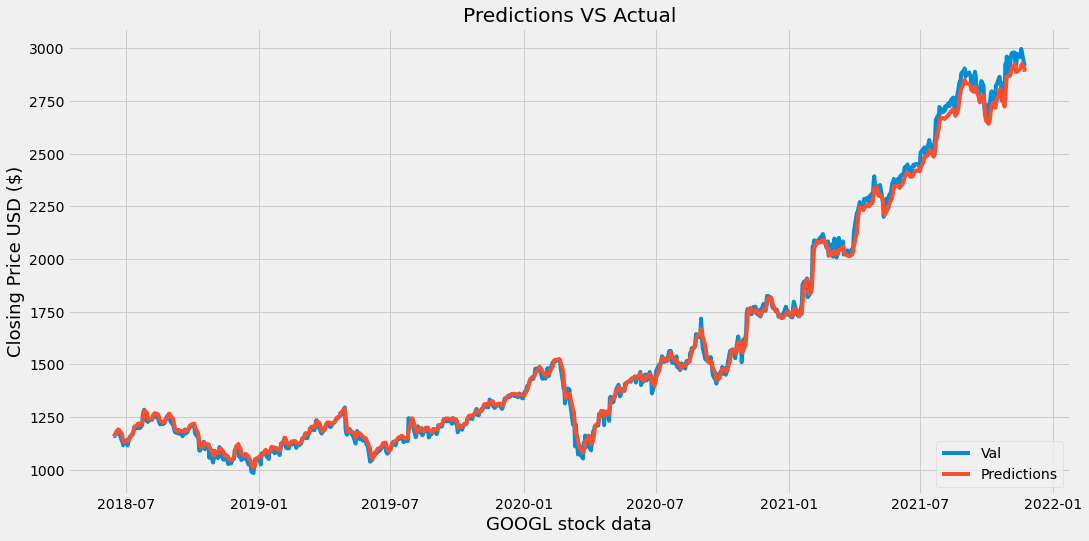

In [302]:
# Plot data
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['Predictions'] = predictions

# Visualize data
plt.figure(figsize=(16,8))
plt.title('Predictions VS Actual')
plt.xlabel(stock + ' stock data', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [303]:
# Show all valid and predicted prices
valid

,Close,Predictions
Date,,
2018-06-14,1160.109985,1158.411865
2018-06-15,1159.270020,1164.345337
2018-06-18,1183.579956,1176.694458
2018-06-19,1178.689941,1185.293335
2018-06-20,1184.069946,1191.819702
...,...,...
2021-11-17,2960.939941,2905.579102
2021-11-18,2996.770020,2919.254639
2021-11-19,2978.530029,2925.137939
